In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models.unet import UNET, make_Jaccard_XEntropy_Loss
from data.make_dataset import load_train_images
from keras_contrib.losses.jaccard import jaccard_distance
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
train, val, y_train, y_val = load_train_images()

In [3]:
_, height, width, channel = train.shape
input_shape = (height, width, channel)

In [46]:
unet = UNET(input_shape,3,[4,8,16,32],3,batch_norm=True)

In [47]:
unet.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 4)  40          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 4)  148         conv2d_58[0][0]                  
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 256, 256, 4)  16          conv2d_59[0][0]                  
____________________________________________________________________________________________

In [8]:
jaccard_xentropy = make_Jaccard_XEntropy_Loss(0.9)

In [9]:
class_weights = compute_class_weight('balanced',np.unique(y_train),y_train.flatten())
class_weights

array([ 0.35621142, 16.19044074,  7.63862767])

In [48]:
unet.model.compile(optimizer=Adam(lr=1e-3),loss=jaccard_xentropy,metrics=[jaccard_distance, 'accuracy'])

In [49]:
# we create two instances with the same arguments
data_gen_args = dict(rotation_range=0,
                     zoom_range=0.,
                     fill_mode='reflect')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 42
image_generator = image_datagen.flow(train[:10],batch_size=1,seed=42)

mask_generator = mask_datagen.flow(to_categorical(y_train[:10],3),batch_size=1,seed=42)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [ ]:
for x_batch, y_batch in train_generator:
    plt.subplot(1,2,1)
    plt.imshow(x_batch[0,:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(y_batch[0,:,:,0])
    plt.show()
    import pdb; pdb.set_trace()

In [50]:
unet.model.fit_generator(train_generator,steps_per_epoch=10*len(train[:10]),epochs=10,shuffle=True,validation_data=(val[:10],to_categorical(y_val[:10],3)),workers=4)

Epoch 1/10
100/100 [==============================] - 28s 280ms/step - loss: 0.6626 - jaccard_distance: 0.6772 - accuracy: 0.7864 - val_loss: 0.3556 - val_jaccard_distance: 0.3526 - val_accuracy: 0.9460
Epoch 2/10
100/100 [==============================] - 23s 227ms/step - loss: 0.0836 - jaccard_distance: 0.0811 - accuracy: 0.9600 - val_loss: 0.1281 - val_jaccard_distance: 0.1108 - val_accuracy: 0.9625
Epoch 3/10
100/100 [==============================] - 22s 220ms/step - loss: 0.0598 - jaccard_distance: 0.0601 - accuracy: 0.9601 - val_loss: 0.1045 - val_jaccard_distance: 0.0760 - val_accuracy: 0.9630
Epoch 4/10
100/100 [==============================] - 22s 222ms/step - loss: 0.0562 - jaccard_distance: 0.0568 - accuracy: 0.9601 - val_loss: 0.1106 - val_jaccard_distance: 0.0809 - val_accuracy: 0.9630
Epoch 5/10
100/100 [==============================] - 22s 223ms/step - loss: 0.0547 - jaccard_distance: 0.0554 - accuracy: 0.9601 - val_loss: 0.1106 - val_jaccard_distance: 0.0797 - val_ac

In [76]:
preds = unet.model.predict(val[:10],verbose=1)

10/10 [==============================] - 1s 54ms/step


In [77]:
preds.shape

(10, 256, 256, 3)

In [78]:
preds = preds.argmax(-1)

In [79]:
preds.shape

(10, 256, 256)

In [80]:
uniq, counts = np.unique(preds, return_counts=True)

In [81]:
counts/counts.sum()

array([9.92076111e-01, 7.79571533e-03, 1.28173828e-04])

In [82]:
uniq

array([0, 1, 2])

In [83]:
uniq, counts = np.unique(y_val, return_counts=True)

In [84]:
counts/counts.sum()

array([0.93738975, 0.01963868, 0.04297157])

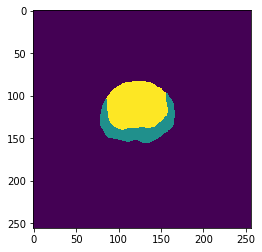

In [88]:
plt.imshow(y_val[9,:,:,0])

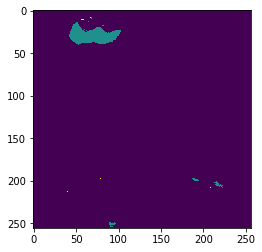

In [89]:
plt.imshow(preds[9,:,:])

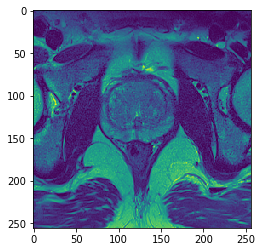

In [90]:
plt.imshow(val[9,:,:,0])